In [1]:
import matplotlib.pyplot as plt
import numpy as np

from AnastrisTNG import TNGsimulation

from gal3d.analyzer import Gal3DAnalyzer
from gal3d.point import Particles
from gal3d.field import SphField
from gal3d.shape import Structure3D
from gal3d.optimization.optimizer import Optimizer
from gal3d.visualization.data_model_residual import show_image_model_residual
from gal3d.visualization.model_projector import ModelProjector
from gal3d.characterization.characterizer import Characterizer


                                         .--,-``-.                    
    ,----..                    ,--,     /   /     '.       ,---,      
   /   /   \                 ,--.'|    / ../        ;    .'  .' `\    
  |   :     :                |  | :    \ ``\  .`-    ' ,---.'     \   
  .   |  ;. /                :  : '     \___\/   \   : |   |  .`\  |  
  .   ; /--`      ,--.--.    |  ' |          \   :   | :   : |  '  |  
  ;   | ;  __    /       \   '  | |          /  /   /  |   ' '  ;  :  
  |   : |.' .'  .--.  .-. |  |  | :          \  \   \  '   | ;  .  |  
  .   | '_.' :   \__\/: . .  '  : |__    ___ /   :   | |   | :  |  '  
  '   ; : \  |   ," .--.; |  |  | '.'|  /   /\   /   : '   : | /  ;   
  '   | '/  .'  /  /  ,.  |  ;  :    ; / ,,/  ',-    . |   | '` ,/    
  |   :    /   ;  :   .'   \ |  ,   /  \ ''\        ;  ;   :  .'      
   \   \ .'    |  ,     .-./  ---`-'    \   \     .'   |   ,.'        
    `---`       `--`---'                 `--`-,,-'     '---'          

    

In [2]:
path = '/home/yxi/Simulation/TNG50-1/TNG50-1/output'
snap =99
snapshot = TNGsimulation.Snapshot(path,snap)

In [3]:
ID = 516760        
sub = snapshot.load_particle(ID,order='star')
sub.physical_units()
coor_trans = sub.face_on(alignwith='star',rmax=8)

In [4]:
pos = sub.s['pos'].view(np.ndarray)
mass=sub.s['mass'].view(np.ndarray)
softening_length = float(sub['eps'].in_units('kpc'))
Volume = (4/3*np.pi*(softening_length*3)**3)
outer_value = np.mean(mass)/Volume

In [5]:
particle = Particles(pos = pos,mass=mass,rmax=30,estimator_kwargs={"k_nearest":32,"r_cut": 10*softening_length})

[2025-04-24 13:00:08.781] < gal3d.particle.density_estimator >
  >>>  | INFO | Find DensityEstimatorPlugin: DensityEstimatorKNN and load successfully
[2025-04-24 13:00:08.782] < gal3d.particle.density_estimator >
  >>>  | INFO | Successfully loaded density estimator plugins
[2025-04-24 13:00:08.782] < gal3d.particle.density_estimator.DensityEstimatorKNN >
  >>>  | INFO | cpu nums: 16
[2025-04-24 13:00:08.783] < gal3d.particle.density_estimator.DensityEstimatorKNN >
  >>>  | INFO | Build KDtree with options {'leafsize': 32, 'compact_nodes': True, 'copy_data': False, 'balanced_tree': True, 'boxsize': None}


In [6]:
Num_rays = min(1024,int(len(particle.r)/100))
Num_rays = max(Num_rays,int(len(particle.r)/10000))

In [7]:
field = SphField(particle,num_ray=Num_rays,ray_method='fibonacci'
    ).build_field_boundary(inner=softening_length/2,inner_mode='dist',outer=outer_value,outer_mode='value'
                           
    ).build_profile_sample(num_p=500,step_mode='log'
    ).build_profile_interpolator(interpolator_method='LU',
    ).build_isodensity_profile(method='pair',from_rays_func=False,res_b=0.2,res_c=0.1,num_p=500,interpolator_method='LU')

[2025-04-24 13:00:22.571] < gal3d.preprocessing.spherical_field.spherical_vector >
  >>>  | INFO | Sampling 1024 random points on the sphere by fibonacci method
[2025-04-24 13:00:22.595] < gal3d.preprocessing.spherical_field.spherical_vector >
  >>>  | INFO | 1024 points on the sphere by fibonacci method have the uniformity of 99.688%
[2025-04-24 13:00:22.604] < gal3d.preprocessing.spherical_field.spherical_vector >
  >>>  | INFO | Splitting points into 5 parts, prevent memory overflow
[2025-04-24 13:00:25.777] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO | Ray 519 has the maximum particle count of 4355. 
[2025-04-24 13:00:25.778] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO | Ray 1004 has the minimum particle count of 256. 
[2025-04-24 13:00:26.098] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO |  build ray vector: 3.52641 sec
[2025-04-24 13:00:26.099] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO | Field inner boundaries range

In [8]:
ellipsoid_s = Structure3D(coordinate='EulerShift',geometry='Ellipsoid_S',error_func='sums_dev_rscale',error_method='isodensity_dcall')

[2025-04-24 13:00:40.435] < gal3d.shape.geometry >
  >>>  | INFO | Find GeometryPlugin: Ellipsoid and load successfully
[2025-04-24 13:00:40.977] < gal3d.shape.geometry >
  >>>  | INFO | Find GeometryPlugin: Ellipsoid_S and load successfully
[2025-04-24 13:00:40.978] < gal3d.shape.geometry >
  >>>  | INFO | Successfully loaded geometry plugins
[2025-04-24 13:00:40.979] < gal3d.shape.coordinate >
  >>>  | INFO | Find CoordinatePlugin: EulerShift and load successfully
[2025-04-24 13:00:40.980] < gal3d.shape.coordinate >
  >>>  | INFO | Successfully loaded coordinate plugins


In [9]:
optimizer = Optimizer.get_plugin(plugin = 'OptimizerScipy')(algorithm='Powell') # OptimizerScipy Powell

[2025-04-24 13:01:00.044] < gal3d.optimization.optimizer >
  >>>  | INFO | Find OptimizerPlugin: OptimizerNLopt and load successfully
[2025-04-24 13:01:00.046] < gal3d.optimization.optimizer >
  >>>  | INFO | Find OptimizerPlugin: OptimizerOptimagic and load successfully
[2025-04-24 13:01:00.047] < gal3d.optimization.optimizer >
  >>>  | INFO | Find OptimizerPlugin: OptimizerScipy and load successfully
[2025-04-24 13:01:00.047] < gal3d.optimization.optimizer >
  >>>  | INFO | Successfully loaded optimizer plugins


In [10]:
gal_ellipsoid_s = Gal3DAnalyzer(particle=particle,field=field,structure=ellipsoid_s,optimizer=optimizer)

In [11]:
r_min = 3*softening_length
r_max = 100*softening_length
r_fit = np.geomspace(max(r_min,field.iso_pro_r[0]),min(field.iso_pro_r[-1],r_max),300)

In [12]:
res_ellipsoid_s = gal_ellipsoid_s.fit(r=r_fit)

[2025-04-24 13:01:15.302] < gal3d.analyzer >
  >>>  | INFO | Use get_ell_structure workflow
100%|██████████| 300/300 [01:04<00:00,  4.65it/s]


In [13]:
ellipsoid_s_model = ModelProjector.get_plugin('ProjectorLineIntegration')(res_ellipsoid_s)

In [14]:
bar = Characterizer.get_plugin('Bar')
data = {i: res_ellipsoid_s[i] for i in ['a','eps_ab','eps_bc','ang1','ang2','ang3']}
dex = np.argsort(data['a'])
for i in ['a','eps_ab','eps_bc','ang1','ang2','ang3']:
    data[i] = data[i][dex]
data['pa'] = data['ang1']
bar(data).measure()

[2025-04-24 13:02:24.284] < gal3d.characterization.characterizer >
  >>>  | INFO | Find CharacterizerPlugin: Bar and load successfully
[2025-04-24 13:02:24.285] < gal3d.characterization.characterizer >
  >>>  | INFO | Successfully loaded Characterizer plugins


{'flag': 1,
 'eps_max': np.float64(0.30088418598661293),
 'R_max': np.float64(0.9238441094501043),
 'R_bar': np.float64(1.3254837278082283)}

[2025-04-24 13:02:28.741] < gal3d.visualization.model_projector >
  >>>  | INFO | Cache image, register input hash: (np.float64(-25.0), np.float64(25.0), np.float64(-25.0), np.float64(25.0), 200, np.float64(-25.0), np.float64(25.0), b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?')
100%|██████████| 21561/21561 [00:01<00:00, 12639.85it/s]
[2025-04-24 13:02:34.776] < gal3d.visualization.model_projector >
  >>>  | INFO | Cache image, register input hash: (-5.0, 5.0, -5.0, 5.0, 100, np.float64(-25.0), np.float64(25.0), b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

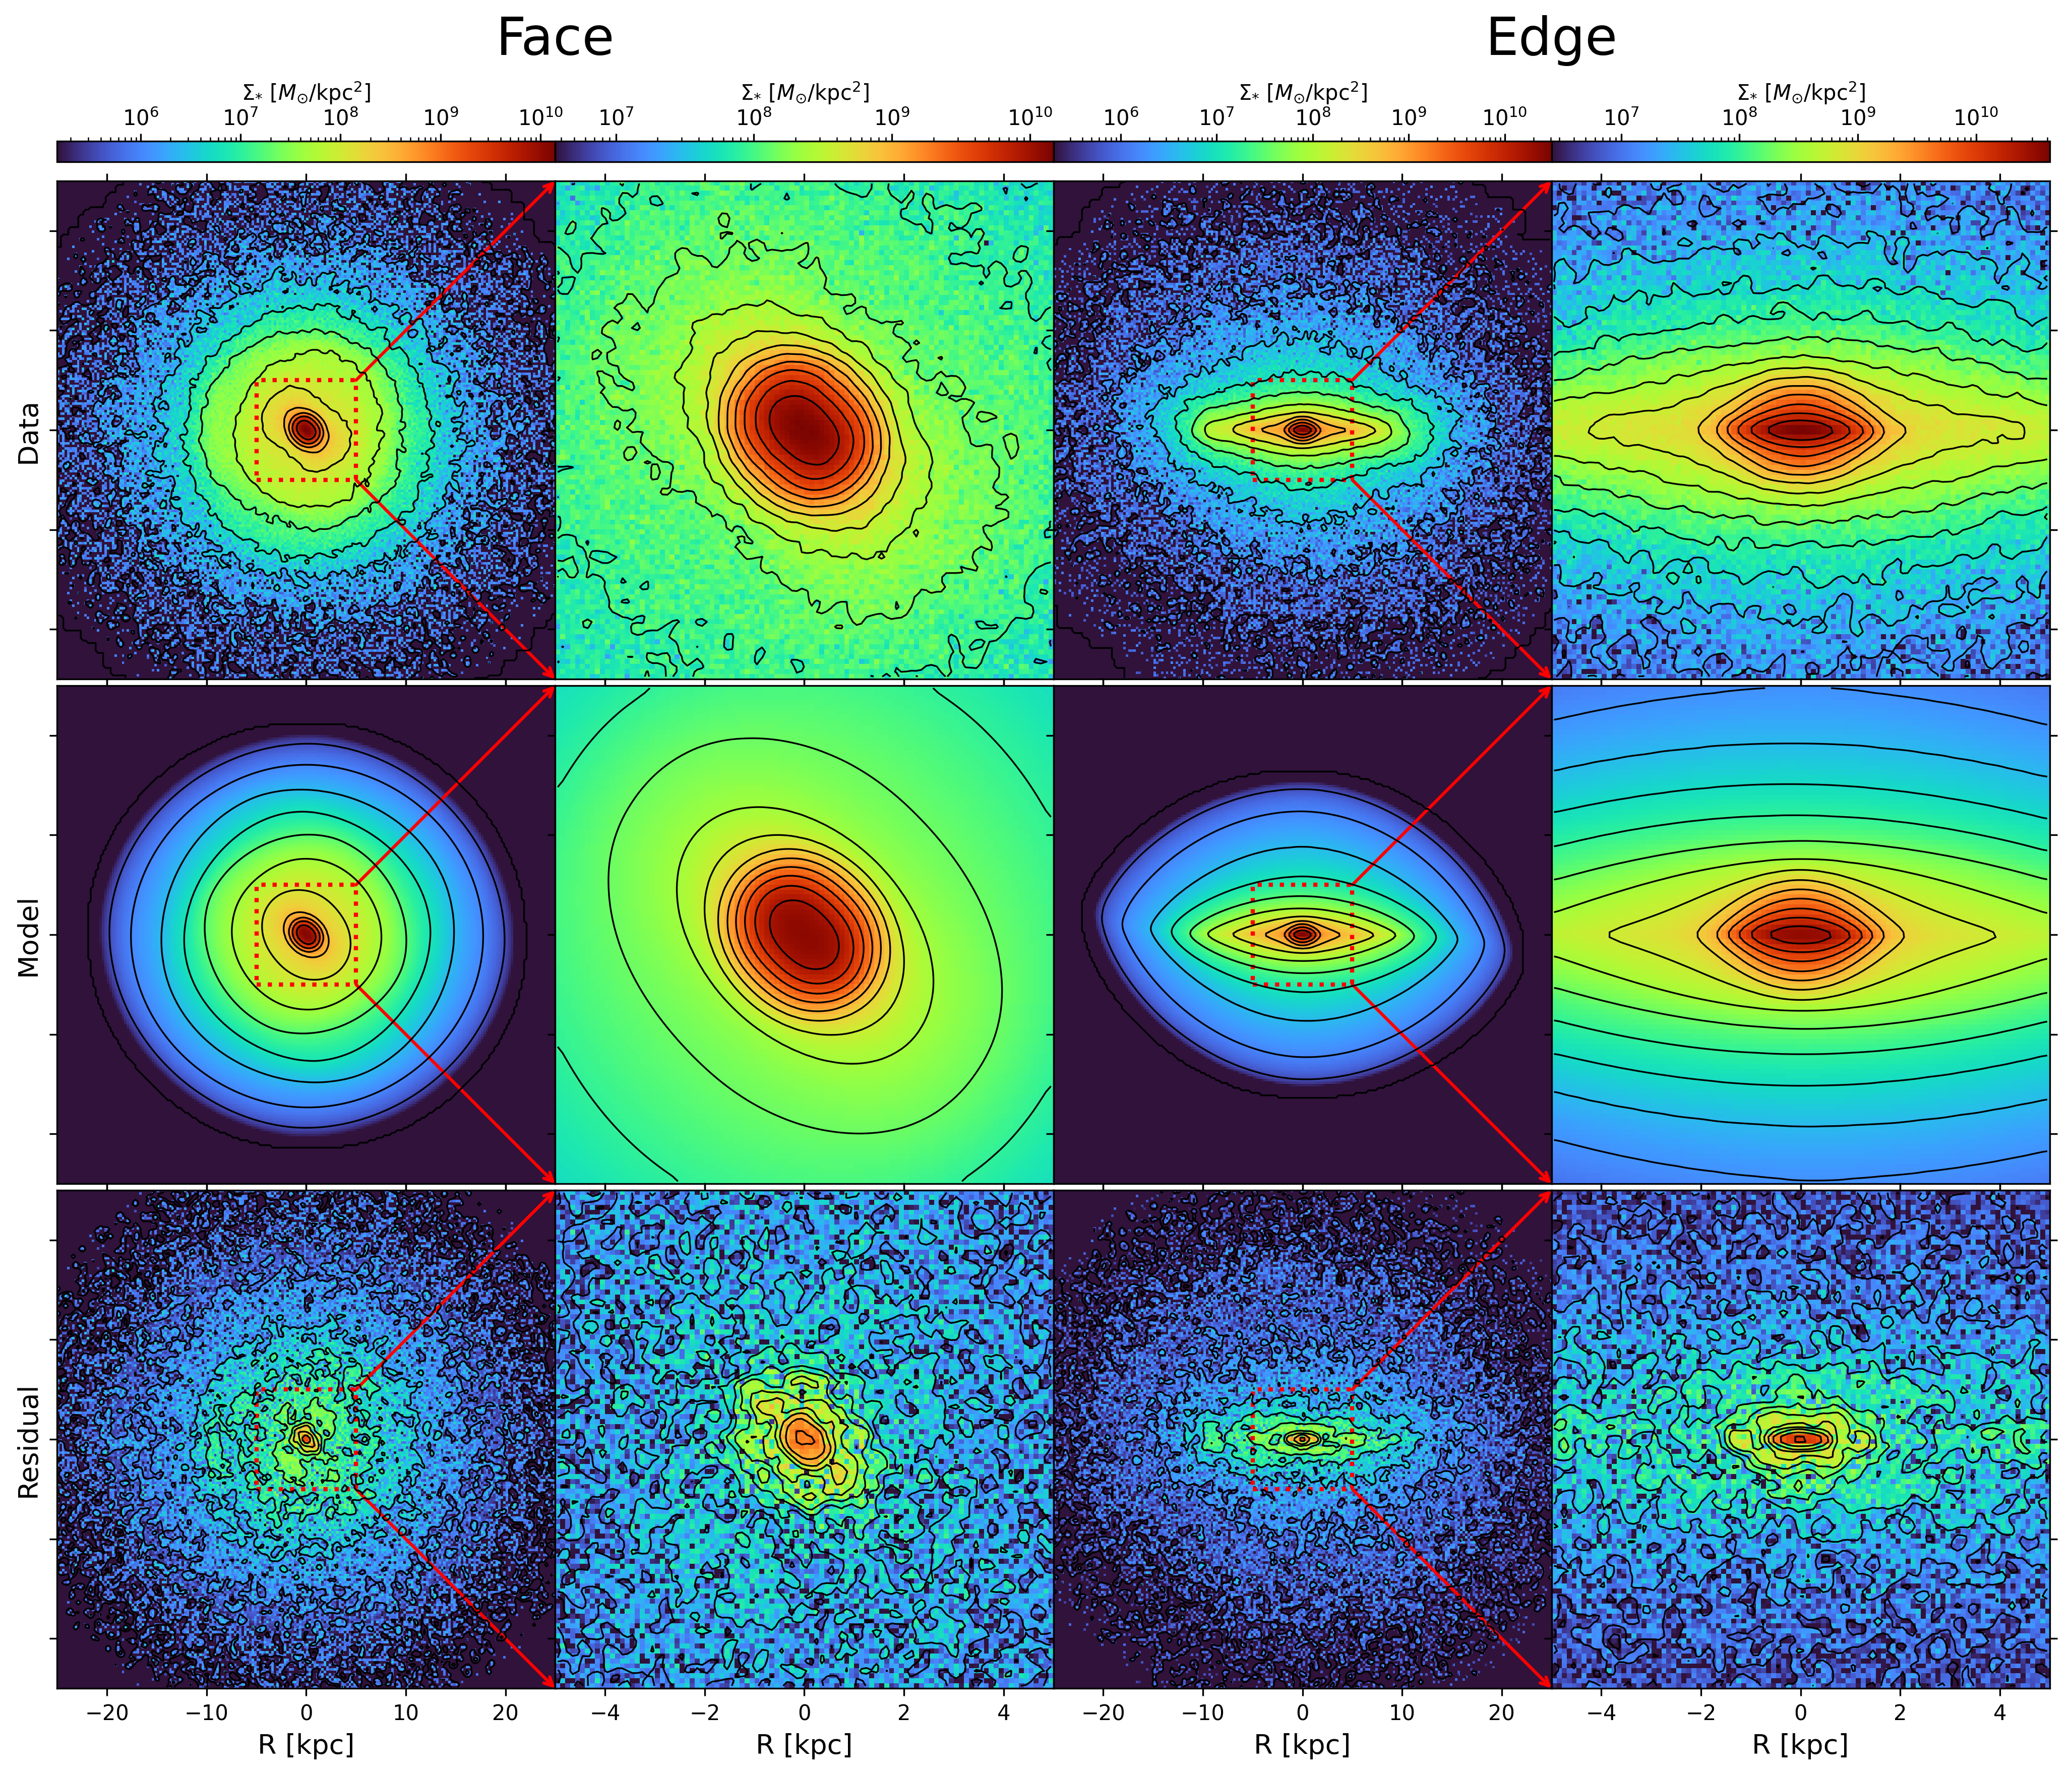

In [15]:
box_lh_max =(np.max(res_ellipsoid_s['a'])//5+1)*5
zoom_lh_max = min(5.,box_lh_max/3)
show_image_model_residual(particle,ellipsoid_s_model,
                          large_box_x_range = (-box_lh_max,box_lh_max),
                          large_box_y_range= (-box_lh_max,box_lh_max),
                          zoom_x_range=(-zoom_lh_max,zoom_lh_max),
                          zoom_y_range=(-zoom_lh_max,zoom_lh_max),
                          depth_z_range=(-box_lh_max,box_lh_max),)